## Introduction

This Ugrainium recipe uses groupings of ingredients to try to cover nutritional requirements with enough overlap that a single ingredient with quality issues does not cause a failure for the whole recipe. An opimizer is used to find the right amount of each ingredient to fulfill the nutritional and practical requirements.

## To Do

* Nutrients without an upper limit should have the upper limit constraint removed
* Add constraints for the NIH essential protein combinations as a limit
* Add a radar graph for vitamins showing the boundry between RDI and UL
* Add a radar graph for vitamins without an upper limit but showing the RDI
* Add a radar graph for essential proteins showing the range between RDI and UL
* Add a radar graph for essential proteins without an upper limit, but showing the RDI as the lower limit
* Add a radar graph pair for non-essential proteins with the above UL and no UL pairing
* Add equality constraints for at least energy, and macro nutrients if possible

In [2]:
# Import all of the helper libraries 

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import least_squares, lsq_linear, dual_annealing, minimize
import pandas as pd
import numpy as np
import os
import json
from math import e, log, log10
import copy, math
import matplotlib.pyplot as plt
import seaborn as sns
#from ipysheet import from_dataframe, to_dataframe

In [3]:
#!pip install seaborn
#!pip install ipysheet
#!pip install ipywidgets
#!pip install matplotlib

In [4]:
# Setup the notebook context

data_dir = '../src/data'
pd.set_option('display.max_columns', 70)
np.set_printoptions(precision=2)

# Our Data

The [Google Sheet](https://docs.google.com/spreadsheets/d/1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28/edit#gid=1812860789) contains our ingredients and nutrition profile
The sheet names are "Ingredients" and "Nutrition Profile". The links to the sheets are used to load the data as a Pandas data table. The technique to download the sheet data:

 - Open the Google sheet
 - File > Share > Publish to web
 - From the Link tab, select the sheet to share (Ingredients, Nutrition Profile)
 - From the Embed tab, select *comma-separated values*
 - Click on publish

In [5]:
# Download our nutrition profile data from Google Sheets

# The "Ugrainium" spreadsheet holding the ingredient and nutrient taraget data
ingredient_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTK8Ke1_yh5VJXBhBpGfFxlG6Sc7pcOgdXG_7mbO2mVkzGeZ7SoaMimWPJgGKQ6uqptc4VeluRXJCqV/pub?gid=1812860789&single=true&output=csv'
nutrition_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTK8Ke1_yh5VJXBhBpGfFxlG6Sc7pcOgdXG_7mbO2mVkzGeZ7SoaMimWPJgGKQ6uqptc4VeluRXJCqV/pub?gid=624419712&single=true&output=csv'

nutrition_profile_df = pd.read_csv(nutrition_tab_url, index_col=0, verbose=True)
for col in ['RDI', 'UL', 'Target Scale', 'Target', 'Weight']:
    nutrition_profile_df[col] = nutrition_profile_df[col].astype(float)
nutrition_profile_df = nutrition_profile_df.transpose()
ingredients_df = pd.read_csv(ingredient_tab_url, index_col=0, verbose=True).transpose()

# convert all values to float
for col in ingredients_df.columns:
    ingredients_df[col] = ingredients_df[col].astype(float)
ingredients_df
ingredients_df.shape, nutrition_profile_df.shape

Tokenization took: 0.08 ms
Type conversion took: 1.49 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 0.11 ms
Type conversion took: 1.62 ms
Parser memory cleanup took: 0.01 ms


((19, 61), (8, 61))

# Problem Setup

The goal is to find the right combination of ingredients to optimally satisfy our nutrition target. The amounts which need to be determined for each ingredient is contained in the vector $\vec{w}$. The matrix $A$ contains a nutrient by ingredient table where rows are nutrients and columns are ingredients. The nutrition target which we would like to satisfy is contaned in the vector $\vec{y_t}$.

Combining together, the goal is to minimize the cost function $J(\mathbf{w})$ which is: $$J(\mathbf{w}) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} ((A \vec{w})^{(i)} - y_t^{(i)})^2 \tag{3}$$ 

where m is the number of nutrients

There are some nutrients we only want to track, but not optimize. For example, we want to know how much cholesterol is contained in our recipe, but we don't want to constrain our result to obtain a specific amount of cholesterol as a goal. 

In [46]:
A = ingredients_df.transpose()[nutrition_profile_df.loc['Report Only'] == False].astype(float)
y_t = nutrition_profile_df.loc['Target'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
w = np.zeros(A.shape[1])
alpha = 0.00001  # The learning rate
A.shape, w.shape

((38, 19), (19,))

In [36]:
def J(w, y_t=y_t, A=A):
    '''The cost function J'''
    tot = 0.0
    y = np.dot(A, w)
    return (y_t - y).apply(np.square).sum() / (2 * w.shape[0])

J(w, y_t, A)

479778.74236842105

In [29]:
def grad(w, y_t=y_t, A=A):
    '''The gradient: The slope of the cost function J(), evaluated at w'''
    n = w.shape[0]
    dj_dw = np.zeros((n,))
    for i in range(n):
        err = np.dot(A.iloc[i], w) - y_t[i]
        dj_dw[i] = err
    return dj_dw
        
    

In [30]:
grad(w)

array([-1.60e+03, -2.60e+02, -9.00e+01, -6.00e+01, -1.45e+01, -1.44e+01,
       -6.46e+01, -3.60e+00, -6.00e+01, -3.60e+03, -2.90e+00, -4.10e+00,
       -1.53e+02, -1.02e+03, -3.40e+01, -2.04e+02, -2.00e+00, -2.20e+00,
       -2.72e+01])

The learning rate needs to be very small (1e-6) in order to not overshoot the minima. This is probable due to the data not being normalized and quantities of high numeric value having a high partial derivative

In [47]:
def grad_descent(w, y=y_t, A=A):
    '''Perform gradient descent to find the least cost J() for w'''
    
    for i in range(100):
        dj_dw = grad(w)
        w = w - alpha * dj_dw
        w[w<0] = 0
        cost = J(w)
        print(f"cost: {cost}, w: {w}, dj_dw: {dj_dw}")
        
grad_descent(w)

cost: 453618.9311183677, w: [1.60e-02 2.60e-03 9.00e-04 6.00e-04 1.45e-04 1.44e-04 6.46e-04 3.60e-05
 6.00e-04 3.60e-02 2.90e-05 4.10e-05 1.53e-03 1.02e-02 3.40e-04 2.04e-03
 2.00e-05 2.20e-05 2.72e-04], dj_dw: [-1.60e+03 -2.60e+02 -9.00e+01 -6.00e+01 -1.45e+01 -1.44e+01 -6.46e+01
 -3.60e+00 -6.00e+01 -3.60e+03 -2.90e+00 -4.10e+00 -1.53e+02 -1.02e+03
 -3.40e+01 -2.04e+02 -2.00e+00 -2.20e+00 -2.72e+01]
cost: 429187.35610147024, w: [3.19e-02 5.19e-03 1.80e-03 1.20e-03 2.90e-04 2.87e-04 1.28e-03 7.18e-05
 1.19e-03 7.07e-02 5.71e-05 7.98e-05 3.00e-03 2.03e-02 6.69e-04 4.06e-03
 3.94e-05 4.33e-05 5.34e-04], dj_dw: [-1.59e+03 -2.59e+02 -8.96e+01 -5.98e+01 -1.45e+01 -1.43e+01 -6.37e+01
 -3.58e+00 -5.93e+01 -3.47e+03 -2.81e+00 -3.88e+00 -1.47e+02 -1.01e+03
 -3.29e+01 -2.02e+02 -1.94e+00 -2.13e+00 -2.62e+01]
cost: 406367.01095119864, w: [4.78e-02 7.76e-03 2.69e-03 1.80e-03 4.35e-04 4.30e-04 1.91e-03 1.07e-04
 1.78e-03 1.04e-01 8.42e-05 1.17e-04 4.41e-03 3.02e-02 9.87e-04 6.07e-03
 5.81e-05 6.39

In [11]:
A_full.dot(solution.x).astype(int)

NameError: name 'A_full' is not defined

In [41]:
# Scale the ingredient nutrient amounts for the given quantity of each ingredient given by the optimizer
solution_df = A_full.transpose().mul(solution.x, axis=0) # Scale each nutrient vector per ingredient by the amount of the ingredient
solution_df.insert(0, 'Quantity (g)', solution.x * 100) # Scale to 100 g since that is basis for the nutrient quantities

# Add a row showing the sum of the scaled amount of each nutrient
total = solution_df.sum()
total.name = 'Total'
solution_df = solution_df.append(total)

/tmp/ipykernel_14641/1706994697.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df = solution_df.append(total)


In [42]:
solution_df['Potassium (g)']

Wheat bran, crude        2.08
Barley flour             0.50
Millet Flour             0.00
Buckwheat Flour          0.53
Flaxseed, fresh ground   0.58
Pea Protein Powder       0.00
Soy protein isolate      0.00
Whey protein             0.07
Canola oil               0.00
Multivitamin             0.08
Ascorbic acid            0.00
Calcium and vitamin D    0.00
Vitamin K                0.00
Salt, iodized            0.00
Potassium chloride       3.67
Guar gum                 0.00
Xanthan Gum              0.00
Choline Bitartrate       0.00
Lecithin granules        0.05
Total                    7.57
Name: Potassium (g), dtype: float64

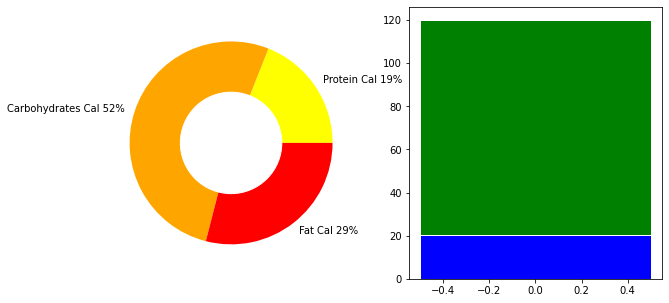

In [43]:
# Plot the macro nutrient profile
# The ratio of Calories for protein:carbohydrates:fat is 4:4:9 kcal/g
pc = solution_df['Protein (g)']['Total'] * 4.0
cc = solution_df['Carbohydrates (g)']['Total'] * 4.0
fc = solution_df['Total Fat (g)']['Total'] * 9.0
tc = pc + cc + fc
p_pct = int(round(pc / tc * 100))
c_pct = int(round(cc / tc * 100))
f_pct = int(round(fc / tc * 100))
(p_pct, c_pct, f_pct)
# create data
names=f'Protein Cal {p_pct}%', f'Carbohydrates Cal {c_pct}%', f'Fat Cal {f_pct}%', 
size=[p_pct, c_pct, f_pct]
 
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

# Give color names
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)
colors = ['yellow','orange','red']
plt.pie(size, labels=names, colors=colors)

#p=plt.gcf()
#p.gca().add_artist(my_circle)
fig.gca().add_artist(my_circle)
#plt.show()

fig.add_subplot(1,2,2)
barWidth = 1
fs = [solution_df['Soluble Fiber (g)']['Total']]
fi = [solution_df['Insoluble Fiber (g)']['Total']]
plt.bar([0], fs, color='blue', edgecolor='white', width=barWidth, label=['Soluble Fiber (g)'])
plt.bar([0], fi, bottom=fs, color='green', edgecolor='white', width=barWidth, label=['Insoluble Fiber (g)'])
plt.show()
# Also show the Omega-3, Omega-6 ratio
# Saturated:Monounsaturated:Polyunsaturated ratios

In [44]:
# Prepare data as a whole for plotting by normalizing and scaling
amounts = solution_df
total = A_full.dot(solution.x) #solution_df.loc['Total']

# Normalize as a ratio beyond RDI
norm = (total) / rdi_full
norm_ul = (ul_full) / rdi_full

nuts = pd.concat([pd.Series(norm.values, name='value'), pd.Series(norm.index, name='name')], axis=1)
norm['Potassium (g)']


1.6116474052931644

In [45]:
# Setup categories of nutrients and a common plotting function
vitamins = ['Vitamin A (IU)','Vitamin B6 (mg)','Vitamin B12 (ug)','Vitamin C (mg)','Vitamin D (IU)',
            'Vitamin E (IU)','Vitamin K (ug)','Thiamin (mg)','Riboflavin (mg)','Niacin (mg)','Folate (ug)','Pantothenic Acid (mg)','Biotin (ug)','Choline (mg)']
minerals = ['Calcium (g)','Chloride (g)','Chromium (ug)','Copper (mg)','Iodine (ug)','Iron (mg)',
            'Magnesium (mg)','Manganese (mg)','Molybdenum (ug)','Phosphorus (g)','Potassium (g)','Selenium (ug)','Sodium (g)','Sulfur (g)','Zinc (mg)']
essential_aminoacids = ['Cystine (mg)','Histidine (mg)','Isoleucine (mg)','Leucine (mg)','Lysine (mg)',
                        'Methionine (mg)','Phenylalanine (mg)','Threonine (mg)','Tryptophan (mg)','Valine (mg)']
other_aminoacids = ['Tyrosine (mg)','Arginine (mg)','Alanine (mg)','Aspartic acid (mg)','Glutamic acid (mg)','Glycine (mg)','Proline (mg)','Serine (mg)','Hydroxyproline (mg)']

def plot_group(nut_names, title):
    nut_names_short = [s.split(' (')[0] for s in nut_names] # Snip off the units from the nutrient names
    
    # Create a bar to indicate an upper limit 
    ul_bar = (norm_ul * 1.04)[nut_names]
    ul_bar[ul_full[nut_names].isnull() == True] = 0
    
    # Create a bar to mask the UL bar so just the end is exposed
    ul_mask = norm_ul[nut_names]
    ul_mask[ul_full[nut_names].isnull() == True] = 0
    
    
    n = []  # normalized values for each bar
    for x, mx in zip(norm[nut_names], ul_mask.values):
        if mx == 0: # no upper limit
            if x < 1.0:
                n.append(1.0 - (x / 2.0))
            else:
                n.append(0.50)
        else:
            n.append(1.0 - (log10(x) / log10(mx)))
    clrs = sm.to_rgba(n, norm=False)
    
    g = sns.barplot(x=ul_bar.values, y=nut_names_short, color='red')
    g.set_xscale('log')
    sns.barplot(x=ul_mask.values, y=nut_names_short, color='white')
    bax = sns.barplot(x=norm[nut_names], y=nut_names_short, label="Total", palette=clrs)
    
    # Add a legend and informative axis label
    g.set( ylabel="",xlabel="Nutrient Mass / RDI (Red Band is UL)", title=title)

    #sns.despine(left=True, bottom=True)

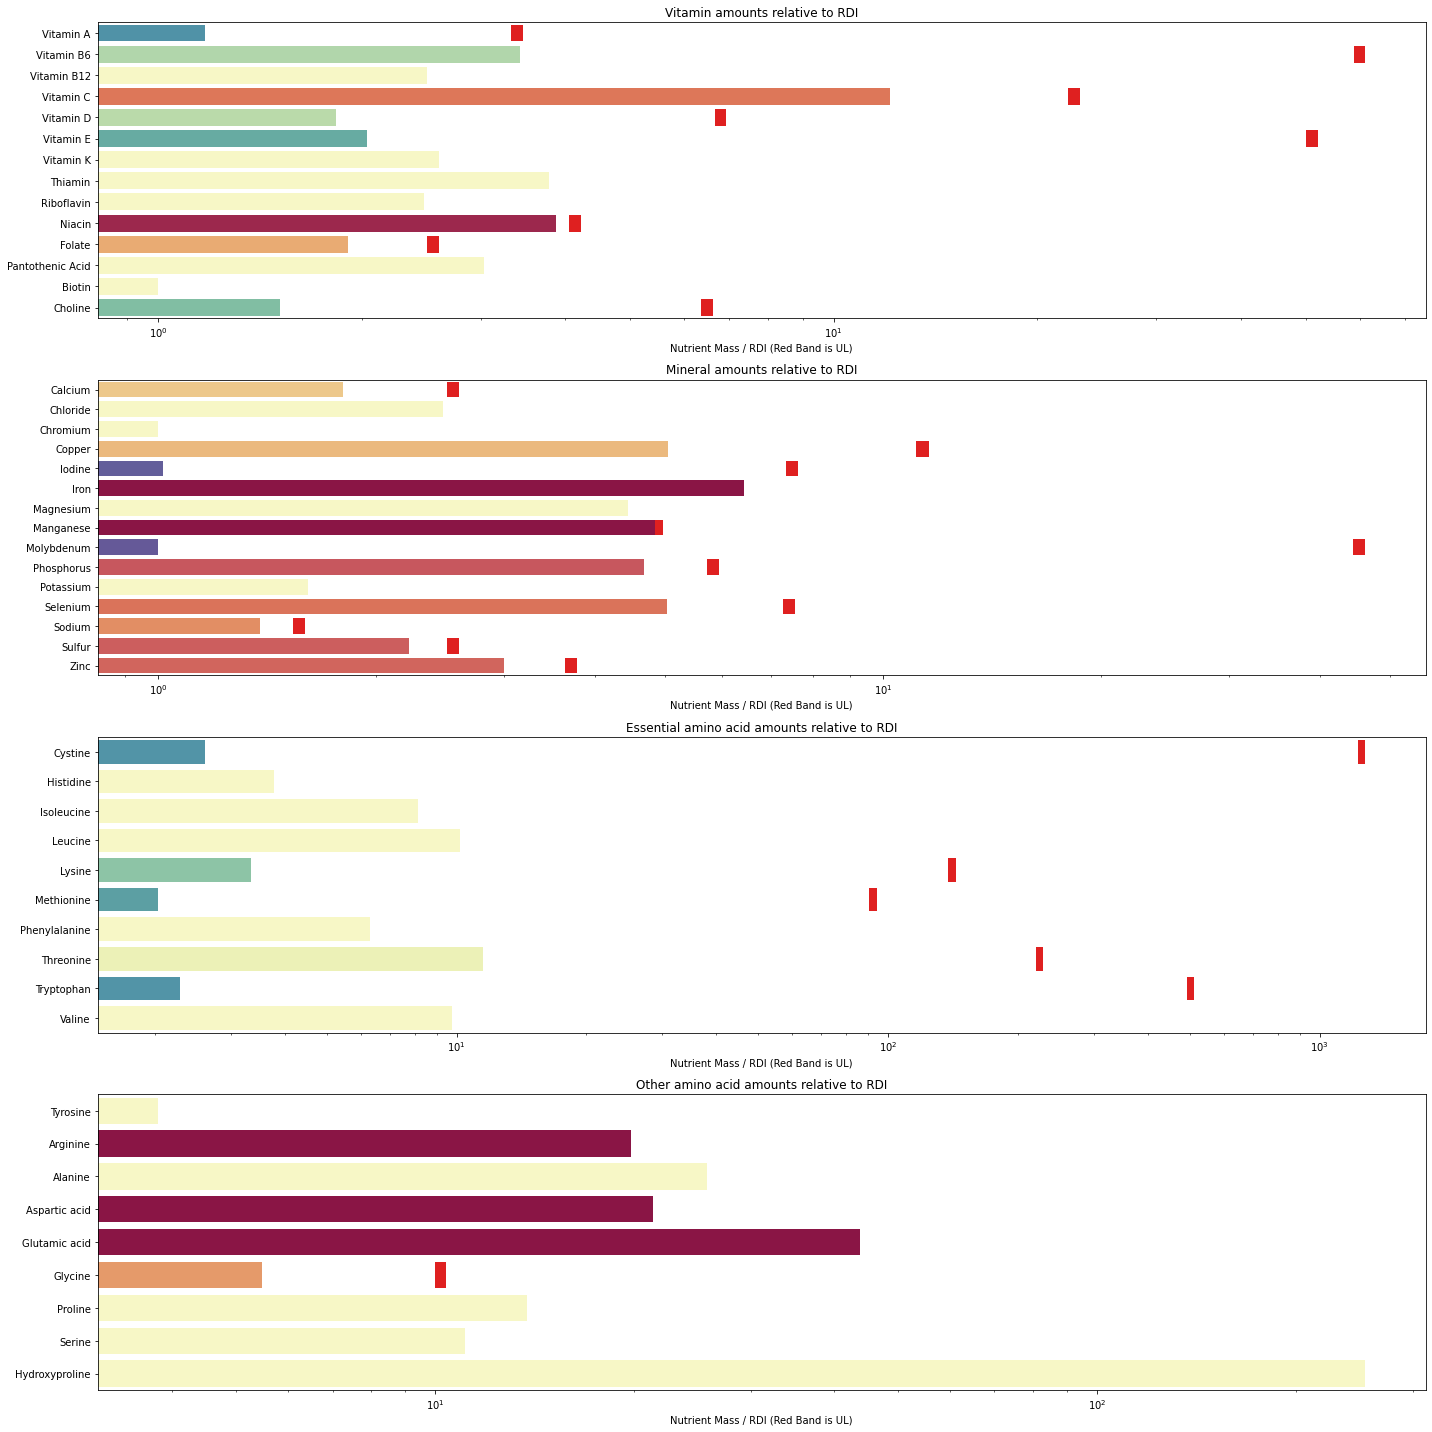

In [46]:
# Construct a group of bar charts for each nutrient group

# Setup the colormap for each bar
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)

#fig = plt.figure(figsize=plt.figaspect(3.))
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plot_group(vitamins,'Vitamin amounts relative to RDI')
fig.add_subplot(4, 1, 2)
plot_group(minerals,'Mineral amounts relative to RDI')
fig.add_subplot(4, 1, 3)
plot_group(essential_aminoacids,'Essential amino acid amounts relative to RDI')
fig.add_subplot(4, 1, 4)
plot_group(other_aminoacids,'Other amino acid amounts relative to RDI')

#fig.show()
fig.tight_layout()

In [47]:
#solu_amount = (solution_df['Quantity (g)'] * 14).astype(int)
pd.options.display.float_format = "{:,.2f}".format
solu_amount = solution_df['Quantity (g)']
solu_amount.index.name = 'Ingredient'
#solu_amount['Batch (g)'] = solu_amount * 14.0
solu_amount.reset_index()
recipe = pd.DataFrame(solu_amount)
recipe['Batch (g)'] = recipe['Quantity (g)'] * 14.0
recipe

,Quantity (g),Batch (g)
Ingredient,,
"Wheat bran, crude",176.10,"2,465.38"
Barley flour,163.05,"2,282.66"
Millet Flour,0.00,0.00
Buckwheat Flour,91.76,"1,284.61"
"Flaxseed, fresh ground",71.58,"1,002.17"
Pea Protein Powder,39.74,556.36
Soy protein isolate,0.00,0.00
Whey protein,15.00,210.00
Canola oil,36.88,516.34


In [48]:
A_full.dot(solution.x).astype(int)['Calories (kcal)']

2198

In [32]:
calories = A_full.dot(solution.x).astype(int)['Calories (kcal)']
#weight = recipe['Quantity (g)']['Total'] - recipe['Quantity (g)']['Vitamin K'] - recipe['Quantity (g)']['Alpha-galactosidase enzyme (Beano)'] - recipe['Quantity (g)']['Multivitamin'] - recipe['Quantity (g)']['Calcium and vitamin D'] 
weight = (recipe['Quantity (g)']['Total'] - recipe['Quantity (g)']['Vitamin K'] - recipe['Quantity (g)']['Multivitamin'] - recipe['Quantity (g)']['Calcium and vitamin D']).astype(int)
cal_by_100g = int(calories / weight * 100.)
'kcal / 100g:', cal_by_100g, 'Weight (g):', weight

('kcal / 100g:', 380, 'Weight (g):', 626)

In [46]:
'Volume of 1/7 of pitcher:', 2000 / 7

('Volume of 1/7 of pitcher:', 285.7142857142857)

In [29]:
meal = pd.DataFrame.from_dict({'Calories (kcal)': range(1000, 2600, 100)})
meal['Measure (g)'] = round(meal['Calories (kcal)'] / cal_by_100g * 100)
print('Amount to measure daily for calorie goal: ')
meal

Amount to measure daily for calorie goal: 


,Calories (kcal),Measure (g)
0,1000,263.00
1,1100,289.00
2,1200,316.00
3,1300,342.00
4,1400,368.00
5,1500,395.00
6,1600,421.00
7,1700,447.00
8,1800,474.00
9,1900,500.00
